In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import comet_ml
experiment = comet_ml.Experiment(project_name="2019nn")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/aeryen/2019nn/d1ab8b0a6a9b410da9e4edbf72b18cb4



In [3]:
# %%
from fastai.text import *
from data_helpers.Data import *
from fastai.text.transform import *

In [4]:
hyper_params = {
    "max_sequence_length": 40*70,
    "moms": (0.8, 0.8, 0.8, 0.8, 0.8),
    "batch_size": 20,
    "num_epochs": 8,
}

In [5]:
experiment.log_parameters(hyper_params)

# Load LM Databunch and LM Learner

In [6]:
# lm_db = load_data("./data/", "hotel_lm_databunch.1001")
# lm_learn = language_model_learner(lm_db, AWD_LSTM)
# lm_learn = lm_learn.load("lang_model_hotel")

In [7]:
# lm_learn.save_encoder('lang_model_hotel_enc')

In [8]:
cls_db = load_data("./data/", "cls_databunch_hotel.allaspect.1115")
cls_db.batch_size=hyper_params["batch_size"]
cls_db.batch_size

20

# Tools

### Sentence Feature Combo Pooling (1200)

In [9]:
def pool_combo(output, start, end):
    avg_pool = output[start:end, :].mean(dim=0)
    max_pool = output[start:end, :].max(dim=0)[0]
    x = torch.cat([output[-1,:], max_pool, avg_pool], 0)
    return x

def sentence_extract_pool(outputs, mask, p_index):
    "Pool MultiBatchEncoder outputs into one vector [last_hidden, max_pool, avg_pool]."
    output = outputs[-1]
    seq_max = output.size(1)
    doc_start = mask.int().sum(dim=1)
    
    batch = []
    for doci in range(0,output.shape[0]):
        pi = p_index[doci,:].nonzero(as_tuple=True)[0].int()
        doc = []
        for senti in range( len(pi) ):
            if senti==0:
                doc.append( pool_combo(output[doci,:,:], doc_start[doci], pi[senti]) )
            else:
                doc.append( pool_combo(output[doci,:,:], pi[senti-1]+1, pi[senti]) )
            
        batch.append( torch.stack(doc, 0) )

    return batch

## DEFINE MODEL

In [10]:
class SentenceEncoder(Module):
    "Create an encoder over `module` that can process a full sentence."
    def __init__(self, bptt:int, max_len:int, module:nn.Module, vocab, pad_idx:int=1):
        print("Encoder init")
        self.max_len,self.bptt,self.module,self.pad_idx = max_len,bptt,module,pad_idx
        self.vocab = vocab
        self.period_index = self.vocab.stoi["xxperiod"]

    def concat(self, arrs:Collection[Tensor])->Tensor:
        "Concatenate the `arrs` along the batch dimension."
        return [torch.cat([l[si] for l in arrs], dim=1) for si in range_of(arrs[0])]

    def reset(self):
        if hasattr(self.module, 'reset'): self.module.reset()

    def forward(self, input:LongTensor)->Tuple[Tensor,Tensor]:
        bs,sl = input.size()
        self.reset()
        raw_outputs,outputs,masks = [],[],[]
        p_index = []
        for i in range(0, sl, self.bptt):
            r, o = self.module(input[:,i: min(i+self.bptt, sl)])
            if i>(sl-self.max_len):
                masks.append(input[:,i: min(i+self.bptt, sl)] == self.pad_idx)
                raw_outputs.append(r)
                outputs.append(o)
                p_index.append( input[:,i: min(i+self.bptt, sl)] == self.period_index )

                
        # print("number of sentences in docs:")
#         n_sent = torch.sum( x==self.vocab.stoi["xxperiod"] , dim=1)
        # print(n_sent)
        
        # print("locating period marks")
        period_index = torch.cat(p_index,dim=1)
        
        return self.concat(raw_outputs),self.concat(outputs), \
               torch.cat(masks,dim=1),period_index

### Baseline 01: Fastai Default

In [10]:
def masked_concat_pool(outputs, mask):
    "Pool MultiBatchEncoder outputs into one vector [last_hidden, max_pool, avg_pool]."
    output = outputs[-1]
    avg_pool = output.masked_fill(mask[:, :, None], 0).mean(dim=1)
    avg_pool *= output.size(1) / (output.size(1)-mask.type(avg_pool.dtype).sum(dim=1))[:,None]
    max_pool = output.masked_fill(mask[:,:,None], -float('inf')).max(dim=1)[0]
    x = torch.cat([output[:,-1], max_pool, avg_pool], 1)
    return x
class SimpleDocModule(Module):
    "Create a linear classifier with pooling."
    def __init__(self, n_asp:int, n_rat:int, layers:Collection[int], drops:Collection[float]):
        print("SimpleDocModule init")
        print("Num Aspect: "+str(n_asp) )
        print("Num Rating: "+str(n_rat) )
        self.n_asp = n_asp
        self.n_rat = n_rat
        
        mod_layers = []
        mod_layers += bn_drop_lin(1200, 60, p=0.4, actn=nn.ReLU(inplace=True))
        mod_layers += bn_drop_lin(60, n_asp*n_rat, p=0, actn=None)
        self.layers = nn.Sequential(*mod_layers)

    def forward(self, input:Tuple[Tensor,Tensor,Tensor,Tensor])->Tuple[Tensor,Tensor,Tensor]:
        raw_outputs,outputs,mask,p_index = input
        
        x = masked_concat_pool(outputs, mask)

        sentiment_dist = self.layers(x)
        sentiment_dist = sentiment_dist.view(-1, self.n_asp, self.n_rat)
        
        return sentiment_dist,raw_outputs,outputs

### Baseline 02: Sentence feature (400) extract then estimate distribution, sent. dist. sumed to doc output

In [11]:
class SimpleSentModule(Module):
    "Create a linear classifier with pooling."
    def __init__(self, n_asp:int, n_rat:int, layers:Collection[int], drops:Collection[float]):
        print("SimpleSentModule init")
        print("Num Aspect: "+str(n_asp) )
        print("Num Rating: "+str(n_rat) )
        self.n_asp = n_asp
        self.n_rat = n_rat
        
        mod_layers = []
#         mod_layers += bn_drop_lin(400, 60, p=0.4, actn=nn.ReLU(inplace=True))
        mod_layers += bn_drop_lin(400, n_asp*n_rat, p=0, actn=None)
        self.layers = nn.Sequential(*mod_layers)

    def forward(self, input:Tuple[Tensor,Tensor,Tensor,Tensor])->Tuple[Tensor,Tensor,Tensor]:
        raw_outputs,outputs,mask,p_index = input

        # takes only last layer output
        output = outputs[-1] # [batch, seq_len, emb_size]

        result = []
        for bati in range(0,output.shape[0]):
            sent_output = output[bati, p_index[bati,:], :]
            sentiment_dist = self.layers(sent_output)
            sentiment_dist = torch.sum(sentiment_dist, dim=0, keepdim=True)
            sentiment_dist = sentiment_dist.view(-1, self.n_asp, self.n_rat)
            result.append(sentiment_dist)
        
        result = torch.cat( result, dim=0 )
        
        return result,raw_outputs,outputs

### Baseline 03: average sentence combo pool feature then do document BMM

In [ ]:
class ClsModule1200avg(Module):
    "Create a linear classifier with pooling."
    def __init__(self, n_asp:int, n_rat:int, layers:Collection[int], drops:Collection[float]):
        print("CLS init")
        print("Num Aspect: "+str(n_asp) )
        print("Num Rating: "+str(n_rat) )
        self.n_asp = n_asp
        self.n_rat = n_rat
        
        mod_layers = []
        mod_layers += bn_drop_lin( 1200, 50, p=0.5, actn=nn.ReLU(inplace=True) )
        mod_layers += bn_drop_lin( 50, self.n_asp+1, p=0, actn=torch.nn.Softmax(dim=1) )
#         mod_layers += bn_drop_lin( 1200, self.n_asp+1, p=0, actn=torch.nn.Softmax(dim=1) )
        self.aspect = nn.Sequential(*mod_layers)
        
        mod_layers = []
        mod_layers += bn_drop_lin( 1200, 50, p=0.5, actn=nn.ReLU(inplace=True) )
        mod_layers += bn_drop_lin( 50, self.n_rat, p=0, actn=torch.nn.Softmax(dim=1) )
#         mod_layers += bn_drop_lin( 1200, self.n_rat, p=0, actn=torch.nn.Softmax(dim=1) )
        self.sentiment = nn.Sequential(*mod_layers)

    def forward(self, input:Tuple[Tensor,Tensor,Tensor,Tensor])->Tuple[Tensor,Tensor,Tensor]:
        raw_outputs,outputs,mask,p_index = input

        output = outputs[-1] # [batch, seq_len, emb_size]

        # print("number of sentences in docs:")
        n_sent = torch.sum( p_index , dim=1)

        batch = sentence_extract_pool(outputs, mask, p_index)
        doc_list = []
        result = []
        for doci in range(0,output.shape[0]):
            sent_output = batch[doci]
            doc_output = sent_output.mean(dim=0, keepdim=True)
            doc_list.append(doc_output)

        doc_list = torch.cat( doc_list, dim=0 )
        aspect_dist = self.aspect(doc_list)         # [aspect]
        sentiment_dist = self.sentiment(doc_list)   # [sentiment]
        result = torch.bmm(aspect_dist.unsqueeze(2), sentiment_dist.unsqueeze(1))
        
        return result,raw_outputs,outputs

## CLS 02: all aspects attributed

In [11]:
class ClsModule1200(Module):
    "Create a linear classifier with pooling."
    def __init__(self, n_asp:int, n_rat:int, layers:Collection[int], drops:Collection[float]):
        print("CLS init")
        print("Num Aspect: "+str(n_asp) )
        print("Num Rating: "+str(n_rat) )
        self.n_asp = n_asp
        self.n_rat = n_rat
        
        mod_layers = []
        mod_layers += bn_drop_lin( 1200, 50, p=0.5, actn=nn.ReLU(inplace=True) )
        mod_layers += bn_drop_lin( 50, self.n_asp+1, p=0, actn=torch.nn.Softmax(dim=1) )
        self.aspect = nn.Sequential(*mod_layers)
        
        mod_layers = []
        mod_layers += bn_drop_lin( 1200, 50, p=0.5, actn=nn.ReLU(inplace=True) )
        mod_layers += bn_drop_lin( 50, self.n_rat, p=0, actn=torch.nn.Softmax(dim=1) )
        self.sentiment = nn.Sequential(*mod_layers)

    def forward(self, input:Tuple[Tensor,Tensor,Tensor,Tensor])->Tuple[Tensor,Tensor,Tensor]:
        raw_outputs,outputs,mask,p_index = input

        batch = sentence_extract_pool(outputs, mask, p_index)
        
        allsent_emb = torch.cat(batch, dim=0)
        aspect_dist = self.aspect(allsent_emb)         # [n_sentence, aspect]
        sentiment_dist = self.sentiment(allsent_emb)   # [n_sentence, sentiment]
        sent_bmm = torch.bmm(aspect_dist.unsqueeze(2), sentiment_dist.unsqueeze(1))
        
        result = []
        cur = 0
        for doci in range(0, len(batch)):
            sn = batch[doci].shape[0]
            doc = torch.sum(sent_bmm[cur:(cur+sn), :, : ], dim=0, keepdim=True) # [1, 7, 5]
            result.append(doc)
            cur = cur + sn
        
        result = torch.cat( result, dim=0 )
        
        return result,raw_outputs,outputs,aspect_dist,sentiment_dist

# Building Learner

In [12]:
def get_text_classifier(arch:Callable, vocab_sz:int, vocab, n_class:int, bptt:int=70, max_len:int=20*70, config:dict=None,
                        drop_mult:float=1., lin_ftrs:Collection[int]=None, ps:Collection[float]=None,
                        pad_idx:int=1) -> nn.Module:
    "Create a text classifier from `arch` and its `config`, maybe `pretrained`."
    print("CUSTOM DEFINED CLASSIFIER")
    meta = text.learner._model_meta[arch]
    config = ifnone(config, meta['config_clas']).copy()
    for k in config.keys():
        if k.endswith('_p'): config[k] *= drop_mult
    if lin_ftrs is None: lin_ftrs = [50]
    if ps is None:  ps = [0.1]*len(lin_ftrs)
    layers = [config[meta['hid_name']] * 3] + lin_ftrs + [n_class]
    ps = [config.pop('output_p')] + ps
    init = config.pop('init') if 'init' in config else None
    encoder = SentenceEncoder(bptt, max_len, arch(vocab_sz, **config), vocab, pad_idx=pad_idx)
    cls_layer = ClsModule1200(n_asp=6, n_rat=5, layers=layers, drops=ps)
    model = SequentialRNN(encoder, cls_layer)
    return model if init is None else model.apply(init)

In [13]:
def text_classifier_learner(data:DataBunch, arch:Callable, bptt:int=70, max_len:int=20*70, config:dict=None,
                            pretrained:bool=True, drop_mult:float=1., lin_ftrs:Collection[int]=None,
                            ps:Collection[float]=None, **learn_kwargs) -> 'TextClassifierLearner':
    "Create a `Learner` with a text classifier from `data` and `arch`."
    model = get_text_classifier(arch, len(data.vocab.itos), data.vocab, data.c, bptt=bptt, max_len=max_len,
                                config=config, drop_mult=drop_mult, lin_ftrs=lin_ftrs, ps=ps)
    meta = text.learner._model_meta[arch]
    learn = RNNLearner(data, model, split_func=meta['split_clas'], **learn_kwargs)
    if pretrained:
        if 'url' not in meta:
            warn("There are no pretrained weights for that architecture yet!")
            return learn
        model_path = untar_data(meta['url'], data=False)
        fnames = [list(model_path.glob(f'*.{ext}'))[0] for ext in ['pth', 'pkl']]
        learn = learn.load_pretrained(*fnames, strict=False)
        learn.freeze()
    return learn

In [14]:
class MultiLabelCEL(nn.CrossEntropyLoss):
    def forward(self, input, target):
        target = target.long()
        loss = 0
        for i in range(6):
            loss = loss + super(MultiLabelCEL, self).forward(input[:,i,:], target[:,i])
        
        return loss

In [15]:
def multi_acc(preds, targs):
    preds = preds[:,0:6,:]
    preds = preds.contiguous().view(-1, 5)
    preds = torch.max(preds, dim=1)[1]
    targs = targs.contiguous().view(-1).long()
    return (preds==targs).float().mean()

In [16]:
def acc_0(preds, targs):
    preds = torch.max(preds, dim=2)[1]
    targs = targs.contiguous().long()
    return (preds[:,0]==targs[:,0]).float().mean()
def acc_1(preds, targs):
    preds = torch.max(preds, dim=2)[1]
    targs = targs.contiguous().long()
    return (preds[:,1]==targs[:,1]).float().mean()
def acc_2(preds, targs):
    preds = torch.max(preds, dim=2)[1]
    targs = targs.contiguous().long()
    return (preds[:,2]==targs[:,2]).float().mean()
def acc_3(preds, targs):
    preds = torch.max(preds, dim=2)[1]
    targs = targs.contiguous().long()
    return (preds[:,3]==targs[:,3]).float().mean()
def acc_4(preds, targs):
    preds = torch.max(preds, dim=2)[1]
    targs = targs.contiguous().long()
    return (preds[:,4]==targs[:,4]).float().mean()
def acc_5(preds, targs):
    preds = torch.max(preds, dim=2)[1]
    targs = targs.contiguous().long()
    return (preds[:,5]==targs[:,5]).float().mean()

## create the objects

In [17]:
mloss = MultiLabelCEL()
cls_learn = text_classifier_learner(cls_db, AWD_LSTM, 
                                    loss_func=mloss,
                                    metrics=[multi_acc,acc_0,acc_1,acc_2,acc_3,acc_4,acc_5],
                                    bptt=70,
                                    max_len=hyper_params["max_sequence_length"])

CUSTOM DEFINED CLASSIFIER
Encoder init
CLS init
Num Aspect: 6
Num Rating: 5
FREEZING
Sequential(
  (0): Embedding(23008, 400, padding_idx=1)
  (1): EmbeddingDropout(
    (emb): Embedding(23008, 400, padding_idx=1)
  )
)
FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(400, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 400, batch_first=True)
  )
  (1): RNNDropout()
)
UN-FREEZING
Sequential(
  (0): ClsModule1200(
    (aspect): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.5, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Linear(in_features=50, out

In [17]:
cls_learn.load_encoder('lm_enc_hotel.1115')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11173 items)
x: TextList
xxbos we had the most wonderful time at the excellence xxperiod we opted for the excellence club and it was well worht it for the perks xxperiod roberto puello who was the club manager did an extra special job of making us feel welcomed xxperiod we took some great pictures that looked like postcards xxperiod the food was excellent the pizza was close to being our favorite xxperiod the shows were great especially the michael jackson and the 70 's 80 's night xxperiod the french resturant was probably our favorite xxperiod we will definately be back for an anniversary trip xxperiod we made some friends but had plenty of xxunk as well xxperiod the rooms were great and everytime we left and came back it was cleaned , towels restocked and the bar was as well xxperiod,xxbos a truly fantastic place xmas we have just returned from a 2 week xmas new year break at the excellence punta cana xxperiod the hotel is magnif

In [19]:
with experiment.train():
    cls_learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,multi_acc,acc_0,acc_1,acc_2,acc_3,acc_4,acc_5,time
0,8.207804,7.820975,0.476866,0.559775,0.509495,0.462958,0.399037,0.441562,0.488366,01:59
1,7.938330,7.669178,0.485558,0.566997,0.508157,0.455202,0.428992,0.466970,0.487029,02:01
2,7.889560,7.602738,0.496835,0.580637,0.524739,0.458411,0.437283,0.476331,0.503611,02:01
3,7.815281,7.549775,0.499153,0.586520,0.520727,0.461353,0.439690,0.473389,0.513239,02:02
4,7.679858,7.540226,0.502452,0.591067,0.522600,0.471516,0.441562,0.483819,0.504146,02:02
5,7.637667,7.478533,0.506865,0.596416,0.533833,0.476063,0.439957,0.475261,0.519658,02:03
6,7.636369,7.434136,0.508558,0.600428,0.536240,0.472319,0.447713,0.476865,0.517785,02:04
7,7.742325,7.490425,0.506330,0.590800,0.531960,0.476598,0.446376,0.474458,0.517785,02:06


In [20]:
cls_learn.save('cls_learn.1200CLS2.191202')

In [20]:
cls_learn.load('cls_learn.1200CLS2.191202')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11173 items)
x: TextList
xxbos we had the most wonderful time at the excellence xxperiod we opted for the excellence club and it was well worht it for the perks xxperiod roberto puello who was the club manager did an extra special job of making us feel welcomed xxperiod we took some great pictures that looked like postcards xxperiod the food was excellent the pizza was close to being our favorite xxperiod the shows were great especially the michael jackson and the 70 's 80 's night xxperiod the french resturant was probably our favorite xxperiod we will definately be back for an anniversary trip xxperiod we made some friends but had plenty of xxunk as well xxperiod the rooms were great and everytime we left and came back it was cleaned , towels restocked and the bar was as well xxperiod,xxbos a truly fantastic place xmas we have just returned from a 2 week xmas new year break at the excellence punta cana xxperiod the hotel is magnif

In [21]:
cls_learn.unfreeze()

UN-FREEZING
Sequential(
  (0): Embedding(23008, 400, padding_idx=1)
  (1): EmbeddingDropout(
    (emb): Embedding(23008, 400, padding_idx=1)
  )
)
UN-FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(400, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
UN-FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
UN-FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 400, batch_first=True)
  )
  (1): RNNDropout()
)
UN-FREEZING
Sequential(
  (0): ClsModule1200(
    (aspect): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.5, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Linear(in_features=50, out_features=7, bias=True)
      (6): Softmax(dim=1)
    )
    (sen

In [ ]:
with experiment.train():
    cls_learn.fit_one_cycle(12)

epoch,train_loss,valid_loss,multi_acc,acc_0,acc_1,acc_2,acc_3,acc_4,acc_5,time
0,7.630337,7.450988,0.509405,0.598021,0.538379,0.471784,0.449853,0.479540,0.518855,04:24
1,7.372316,7.289713,0.521129,0.626906,0.556833,0.485424,0.450388,0.479273,0.527949,04:20
2,7.341654,7.328556,0.520059,0.618347,0.548275,0.493180,0.446109,0.489168,0.525274,04:23
3,7.373100,7.283681,0.523803,0.626103,0.555496,0.496657,0.453597,0.485156,0.525809,04:22


In [20]:
cls_learn.save('cls_learn.1200CLS2.191202.2')

In [24]:
experiment.end()

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/aeryen/2019nn/4b64da0a3cb64e95bd6e8df946e56f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     sys.cpu.percent.01 [3]              : (0.0, 1.1)
COMET INFO:     sys.cpu.percent.02 [3]              : (0.3, 4.9)
COMET INFO:     sys.cpu.percent.03 [3]              : (0.2, 13.6)
COMET INFO:     sys.cpu.percent.04 [3]              : (0.0, 0.5)
COMET INFO:     sys.cpu.percent.05 [3]              : (0.0, 8.9)
COMET INFO:     sys.cpu.percent.06 [3]              : (0.2, 1.7)
COMET INFO:     sys.cpu.percent.07 [3]              : (0.0, 1.0)
COMET INFO:     sys.cpu.percent.08 [3]              : (0.0, 0.4)
COMET INFO:     sys.cpu.percent.09 [3]              : (0.0, 0.5)
COMET INFO:     sys.cpu.percent.10 [3]              : (0.2, 0.7)
COMET INFO:     sys.cpu.percent.11 [3]              : (0.0, 0.5)
COMET INFO:     sys.cpu.percent.12 [3]             

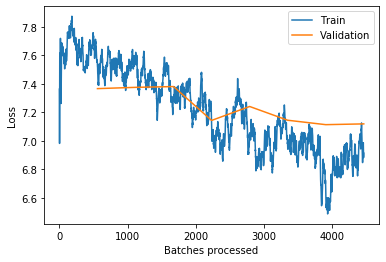

In [21]:
cls_learn.recorder.plot_losses()

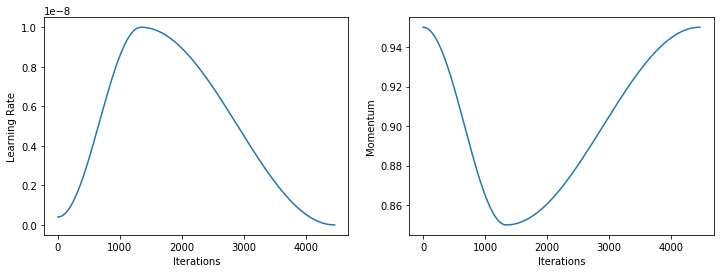

In [29]:
cls_learn.recorder.plot_lr(show_moms=True)

## test output

In [21]:
result = cls_learn.get_preds(ds_type=DatasetType.Valid, ordered=True)

In [22]:
result[0][0,:]

tensor([[-0.5491, -0.9054, -0.2351, -0.6030, -0.0972],
        [-1.3853, -0.7049, -1.2191, -0.7555, -1.1554],
        [-2.3735, -2.3710, -1.8379, -2.0609, -2.4013],
        [-0.8157, -0.7976, -0.3009, -0.4901, -0.4317],
        [ 0.5963,  0.6253,  0.4170,  0.8913,  1.0342],
        [ 1.3833,  1.5860,  1.5821,  1.9504,  1.7124]])

In [23]:
torch.max( result[0][0,:,:], dim=1 )

torch.return_types.max(
values=tensor([-0.0972, -0.7049, -1.8379, -0.3009,  1.0342,  1.9504]),
indices=tensor([4, 1, 2, 2, 4, 3]))

In [24]:
result[1][0]

tensor([1., 0., 0., 3., 1., 1.])

In [31]:
multi_acc(result[0][0:20, :], result[1][0:20])

===
torch.Size([20, 5, 5])
torch.Size([20, 5])
torch.Size([100])
torch.Size([100])


tensor(0.6000)

In [32]:
multi_loss(result[0][0:20, :], result[1][0:20])

tensor(1.1682)

In [36]:
multi_acc(result[0][70:80, :], result[1][70:80])

===
torch.Size([10, 5, 5])
torch.Size([10, 5])
torch.Size([50])
torch.Size([50])


tensor(0.4800)

In [37]:
multi_loss(result[0][70:80, :], result[1][70:80])

tensor(1.4959)